In [1]:
import regions
from numpy import floor, ceil
from astropy import coordinates
from astropy import units as u
import glob
from spectral_cube import SpectralCube
from spectral_cube import wcs_utils
from regions import Regions
from astropy.table import QTable, Table, Column
from astropy.coordinates import SkyCoord
from astropy.io import fits
import numpy as np
import pylab as plt
from astropy.stats import sigma_clip
import statcont
from astropy.stats import mad_std

In [2]:
base = '/orange/adamginsburg/sgrb2/NB/catalog_the_end/'
catNB3 = Table.read(base+'catalog_NB3_4RMS_30.0rings_0.7mindelta3npix_final_Nazar_review.csv', format='ascii')
catMB3 = Table.read(base+'catalog_MB3_4RMS_30.0rings_0.7mindelta3npix_final_Nazar_review.csv', format='ascii')
catNB6 = Table.read(base+'catalog_NB6_4RMS_30.0rings_0.7mindelta3npix_final_Nazar_review.csv', format='ascii')
catMB6 = Table.read(base+'catalog_MB6_4RMS_30.0rings_0.7mindelta3npix_final_Nazar_review.csv', format='ascii')

from purify_catalog import HII_catalogs, cat_purification_cores
catNB3_m, catMB3_m, catNB6_m,catMB6_m = cat_purification_cores(catNB3, catMB3, catNB6, catMB6)

Removed 198 sources for the complete catalog
Removed 9 sources for the medium catalog
Removed 81 sources for the robust catalog
Removed 186 sources for the complete catalog
Removed 7 sources for the medium catalog
Removed 47 sources for the robust catalog
Removed 203 sources for the complete catalog
Removed 6 sources for the medium catalog
Removed 58 sources for the robust catalog
Removed 203 sources for the complete catalog
Removed 8 sources for the medium catalog
Removed 32 sources for the robust catalog


/orange/adamginsburg/sgrb2/NB/python_env_test/lib/python3.9/site-packages/astropy/table/table.py:1412: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  newcol = col[slice_]
/home/nbudaiev/.local/lib/python3.9/site-packages/numpy/ma/core.py:3224: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/home/nbudaiev/.local/lib/python3.9/site-packages/numpy/ma/core.py:3256: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be 

In [3]:
B6_regions_path = '/orange/adamginsburg/sgrb2/NB/python_notebooks/catalog_regions/catB6_m.reg'
regions_B6 = Regions.read(B6_regions_path, format='ds9')

In [6]:
cores_NB6 = SkyCoord(catNB6_m['x_peak'],catNB6_m['y_peak'], unit='deg',)
cores_MB6 = SkyCoord(catMB6_m['x_peak'],catMB6_m['y_peak'], unit='deg',)
cores_NB3 = SkyCoord(catNB3_m['x_peak'],catNB3_m['y_peak'], unit='deg',)
cores_MB3 = SkyCoord(catMB3_m['x_peak'],catMB3_m['y_peak'], unit='deg',)

In [7]:
# wcs coordinates of the brightest pixel in each core detection

dict_cores_NB6 = {catNB6_m['_name'].value[i] : 
                   SkyCoord(catNB6_m['x_peak'],catNB6_m['y_peak'], unit='deg',)[i] 
                   for i in range(len(catNB6_m))}

dict_cores_MB6 = {catMB6_m['_name'].value[i] : 
                   SkyCoord(catMB6_m['x_peak'],catMB6_m['y_peak'], unit='deg',)[i] 
                   for i in range(len(catMB6_m))}

dict_cores_NB3 = {catNB3_m['_name'].value[i] : 
                   SkyCoord(catNB3_m['x_peak'],catNB3_m['y_peak'], unit='deg',)[i] 
                   for i in range(len(catNB3_m))}

dict_cores_MB3 = {catMB3_m['_name'].value[i] : 
                   SkyCoord(catMB3_m['x_peak'],catMB3_m['y_peak'], unit='deg',)[i] 
                   for i in range(len(catMB3_m))}

dict_cores_ = [dict_cores_NB6, dict_cores_MB6, dict_cores_NB3, dict_cores_MB3]

In [8]:
# Cubes
basepath = '/orange/adamginsburg/sgrb2/2016.1.00550.S/FITS/'
product_dict_NB6 = {'SgrB2_NB6_spw0': f"{basepath}full_SgrB2N_spw0_lines.fits",
                'SgrB2_NB6_spw1': f"{basepath}full_SgrB2N_spw1_lines.fits",
                'SgrB2_NB6_spw2': f"{basepath}full_SgrB2N_spw2_lines.fits",
                'SgrB2_NB6_spw3': f"{basepath}full_SgrB2N_spw3_lines.fits",
                   }
product_dict_MB6 = {'SgrB2_MB6_spw0': f"{basepath}full_SgrB2M_spw0_lines.fits",
                'SgrB2_MB6_spw1': f"{basepath}full_SgrB2M_spw1_lines.fits",
                'SgrB2_MB6_spw2': f"{basepath}full_SgrB2M_spw2_lines.fits",
                'SgrB2_MB6_spw3': f"{basepath}full_SgrB2M_spw3_lines.fits",
                    }

product_dict_NB3 = {'SgrB2_NB3_spw0': f'{basepath}sgr_b2m.N.spw0.B3.big.lines.clarkclean5000.robust0.5.image.pbcor.fits',
                   'SgrB2_NB3_spw1': f'{basepath}sgr_b2m.N.spw1.B3.big.lines.clarkclean5000.robust0.5.image.pbcor.fits',
                   'SgrB2_NB3_spw2': f'{basepath}sgr_b2m.N.spw2.B3.big.lines.clarkclean5000.robust0.5.image.pbcor.fits',
                   'SgrB2_NB3_spw3': f'{basepath}sgr_b2m.N.spw3.B3.big.lines.clarkclean5000.robust0.5.image.pbcor.fits',
                  }
product_dict_MB3 = {'SgrB2_MB3_spw0': f'{basepath}sgr_b2m.M.spw0.B3.big.lines.clarkclean5000.robust0.5.image.pbcor.fits',
                   'SgrB2_MB3_spw1': f'{basepath}sgr_b2m.M.spw1.B3.big.lines.clarkclean5000.robust0.5.image.pbcor.fits',
                   'SgrB2_MB3_spw2': f'{basepath}sgr_b2m.M.spw2.B3.big.lines.clarkclean5000.robust0.5.image.pbcor.fits',
                   'SgrB2_MB3_spw3': f'{basepath}sgr_b2m.M.spw3.B3.big.lines.clarkclean5000.robust0.5.image.pbcor.fits',
                  }

product_dict_ = [product_dict_NB6, product_dict_MB6, product_dict_NB3, product_dict_MB3]

In [9]:
# select fldconf
# pick one core
# pefrorm spectral extraction from each of the spws for one core
# combine the extracted spectra
# repeat for each core

In [10]:
# # replace NB6 with fldconf
# core_spec_NB6 = []
# for core in cores_NB6:
#     spec_all_spw = []
#     for spw in product_dict_NB6:
#         #print(spw_cube)
#         spw_cube = product_dict_NB6[spw]
#         cube = SpectralCube.read(spw_cube)
#         x, y = cube.wcs.celestial.world_to_pixel(core)
#         spec = cube[:,int(y),int(x)].value
#         spec_all_spw = np.append(spec_all_spw, spec)
#     core_spec_NB6 += [spec_all_spw]

In [11]:
#spw_cube = product_dict_MB6['SgrB2_MB6_spw0']

In [12]:
#cube = SpectralCube.read(f'{basepath}sgr_b2m.M.spw0.B3.big.lines.clarkclean5000.robust0.5.image.pbcor.fits')

In [13]:
# # not all spectral windows are imaged
# core_spec_MB6 = []
# for core in cores_MB6:
#     spec_all_spw = []
#     for spw in product_dict_MB6:
#         #print(spw_cube)
#         spw_cube = product_dict_MB6[spw]
#         cube = SpectralCube.read(spw_cube)
#         x, y = cube.wcs.celestial.world_to_pixel(core)
#         spec = cube[:,int(y),int(x)].value
#         spec_all_spw = np.append(spec_all_spw, spec)
#     core_spec_MB6 += [spec_all_spw]

In [ ]:
core_spec_NB3 = []

for core in catNB3_m:
    spec_all_spw = []
    freq_all_spw = []
    core_coords = SkyCoord(core['x_peak'],core['y_peak'], unit='deg',)
    core_name = core['_name']
    for spw in product_dict_NB3:
        #print(spw_cube)
        spw_cube = product_dict_NB3[spw]
        cube = SpectralCube.read(spw_cube)
        x, y = cube.wcs.celestial.world_to_pixel(core_coords)
        freq = cube.spectral_axis.to(u.GHz).value
        try:
            spec = cube[:,int(y),int(x)].value
        except:
            spec = [np.nan]*7680
        spec_all_spw = np.append(spec_all_spw, spec)
        freq_all_spw = np.append(freq_all_spw, freq)
    
    #tbl = QTable([freq_all_spw, spec_all_spw])
    #tbl_name = str(core_name)
    #tbl.write(f'spectraNB3/{tbl_name}.dat', format='ascii.no_header',overwrite=True)
        
    core_spec_NB3 += [spec_all_spw]

In [ ]:
core_spec_NB6 = []

for core in catNB6_m:
    spec_all_spw = []
    freq_all_spw = []
    core_coords = SkyCoord(core['x_peak'],core['y_peak'], unit='deg',)
    core_name = core['_name']
    for spw in product_dict_NB6:
        #print(spw_cube)
        spw_cube = product_dict_NB6[spw]
        cube = SpectralCube.read(spw_cube)
        x, y = cube.wcs.celestial.world_to_pixel(core_coords)
        freq = cube.spectral_axis.to(u.GHz).value
        try:
            spec = cube[:,int(y),int(x)].value
        except:
            spec = np.nan
        spec_all_spw = np.append(spec_all_spw, spec)
        freq_all_spw = np.append(freq_all_spw, freq)
    
    #tbl = QTable([freq_all_spw, spec_all_spw])
    #tbl_name = str(core_name)
    #tbl.write(f'spectraNB6/{tbl_name}.dat', format='ascii.no_header',overwrite=True)
        
    core_spec_NB6 += [spec_all_spw]

In [ ]:
#np.save('core_spec_NB3.npy', core_spec_NB3)

In [ ]:
#np.save('core_spec_NB6.npy', core_spec_NB6)

In [ ]:
#############

In [4]:
core_spec_NB3_orig = np.load('core_spec_NB3.npy',allow_pickle=True)
core_spec_NB6 = np.load('core_spec_NB6.npy',allow_pickle=True)
filtered_array = [arr for arr in core_spec_NB3_orig if not np.all(np.isnan(arr))]
core_spec_NB3 = filtered_array

In [5]:
ratios_NB6 = []
for spectra in core_spec_NB6:
    mean_original = np.mean(spectra)
    mean_clipped = np.mean(sigma_clip(spectra, 2))
    ratio = mean_original / mean_clipped
    ratios_NB6 += [ratio]

In [6]:
catNB6_m[0]

_idx,c_ID,_name,area_ellipse,area_exact,flux,peak,ring_std,x_peak_px,y_peak_px,x_peak,y_peak,npix,major_fwhm,minor_fwhm,major_sigma,minor_sigma,position_angle,radius,x_cen,y_cen,x_cen_px,y_cen_px,radial_d_px,radial_d_AU,rejected,core_score,detection_score,B3_match,notes,Schmiedeke16
,,,deg2,deg2,Jy,Jy / beam,Jy / beam,,,,,,deg,deg,deg,deg,deg,,,,,,,AU,,,,,,
int64,int64,int64,float64,float64,float64,float64,float64,int64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str11,str2
67,0,1,2.8876546597679607e-10,1.0802469135804196e-09,0.013360111154504454,0.007188977207988501,0.000352727627963259,2247,2183,266.8330317300807,-28.372021639220787,140,3.0484888960406265e-05,1.2060856459639974e-05,1.2945740386716304e-05,5.121774160658403e-06,177.81332643605722,8.142797959133917e-06,266.8330397844399,-28.372021644527546,2244.4487248587766,2182.9980892771673,67.23148589912324,5714.67630133669,0.0,2,2,6,--,--


In [7]:
from scipy.signal import savgol_filter
Y = savgol_filter(core_spec_NB6[0], 51, 3) # window size 51, polynomial order 3

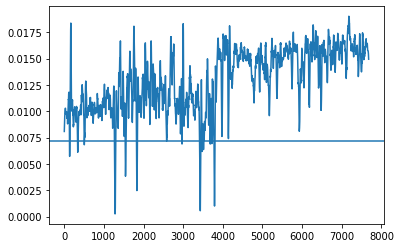

In [8]:
plt.plot(Y)
plt.axhline(0.00718)
plt.show()

In [9]:
catNB6_m[7]

_idx,c_ID,_name,area_ellipse,area_exact,flux,peak,ring_std,x_peak_px,y_peak_px,x_peak,y_peak,npix,major_fwhm,minor_fwhm,major_sigma,minor_sigma,position_angle,radius,x_cen,y_cen,x_cen_px,y_cen_px,radial_d_px,radial_d_AU,rejected,core_score,detection_score,B3_match,notes,Schmiedeke16
,,,deg2,deg2,Jy,Jy / beam,Jy / beam,,,,,,deg,deg,deg,deg,deg,,,,,,,AU,,,,,,
int64,int64,int64,float64,float64,float64,float64,float64,int64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str11,str2
1335,1,27,1.6081892463710942e-10,4.706790123457543e-10,0.007417755246880759,0.0050883530639112,0.000352727627963259,2316,2157,266.8328138973829,-28.37209386128493,61,1.8267554929749593e-05,1.1209190349382976e-05,7.7575163198976e-06,4.760104863654519e-06,-146.9985492802465,6.076725365213066e-06,266.8328107633634,-28.37209307042804,2316.992722619732,2157.2847067536586,114.38597154266523,9722.80758174802,0.0,1,1,--,--,--


In [10]:
errors_arr = []
for spectra in core_spec_NB3_orig:
    try:
        before_clip = np.nanmean(spectra)
        after_clip = np.nanmean(sigma_clip(spectra,2))
        err = (after_clip - before_clip) / (after_clip) * 100
    except:
        err = np.nan
    errors_arr += [err]
    
    
ratios_arr = [] 
for spectra in core_spec_NB3_orig:
    try:
        before_clip = np.nanmean(spectra)
        after_clip = np.nanmean(sigma_clip(spectra,2))
        rat = after_clip/before_clip
    except:
        rat = np.nan
    ratios_arr += [rat]

/scratch/local/10681038/ipykernel_3703656/4182567715.py:4: RuntimeWarning: Mean of empty slice
  before_clip = np.nanmean(spectra)
/scratch/local/10681038/ipykernel_3703656/4182567715.py:4: RuntimeWarning: Mean of empty slice
  before_clip = np.nanmean(spectra)
/scratch/local/10681038/ipykernel_3703656/4182567715.py:4: RuntimeWarning: Mean of empty slice
  before_clip = np.nanmean(spectra)
/scratch/local/10681038/ipykernel_3703656/4182567715.py:4: RuntimeWarning: Mean of empty slice
  before_clip = np.nanmean(spectra)
/scratch/local/10681038/ipykernel_3703656/4182567715.py:4: RuntimeWarning: Mean of empty slice
  before_clip = np.nanmean(spectra)
/scratch/local/10681038/ipykernel_3703656/4182567715.py:4: RuntimeWarning: Mean of empty slice
  before_clip = np.nanmean(spectra)
/scratch/local/10681038/ipykernel_3703656/4182567715.py:4: RuntimeWarning: Mean of empty slice
  before_clip = np.nanmean(spectra)
/scratch/local/10681038/ipykernel_3703656/4182567715.py:4: RuntimeWarning: Mean of 

In [11]:
len(core_spec_NB3_orig)

203

In [12]:
len(catNB3_m)

203

In [13]:
np.array(errors_arr)[np.where(np.abs(np.array(errors_arr)) > 50)]

array([   76.20723246,   349.03389878,  -134.68010355,  -103.43649588,
        -549.80060651,   -54.76939077, -5914.57410638,    81.17029978,
          77.27291189,   -55.63105004,    66.67579612,  -119.31371535])

In [14]:
###

In [15]:
clipped_conts_NB3 = []
for spectra in core_spec_NB3_orig:
    #print(sigma_clip(spectra,2))
    try:
        clipped_conts_NB3 += [np.nanmean(sigma_clip(spectra,2))]
    except:
        clipped_conts_NB3 += [np.nan]

In [16]:
###

(-200.0, 200.0)

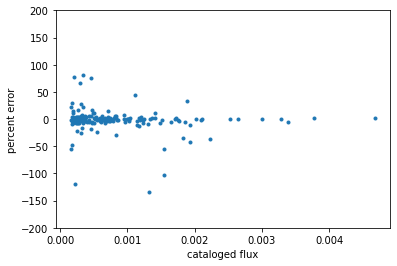

In [17]:
plt.scatter(catNB3_m['peak'],np.array(errors_arr),marker = '.')
plt.xlabel('cataloged flux')
plt.ylabel('percent error')
plt.ylim(-200,200)

In [18]:
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'lines.linewidth': 2})

Text(0.5, 1.0, 'N Band 3')

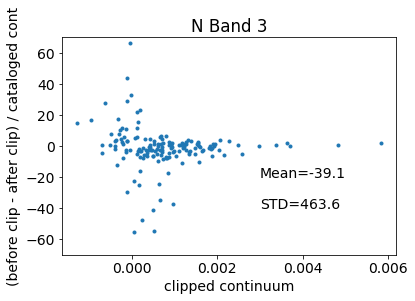

In [19]:
plt.scatter(clipped_conts_NB3,np.array(errors_arr),marker='.')
plt.xlabel('clipped continuum')
plt.ylabel('(before clip - after clip) / cataloged cont')
plt.ylim(-70,70)
mean = np.nanmean(errors_arr)
std = np.nanstd(errors_arr)
plt.text(0.003,-20,'Mean='+str(round(mean,1)))
plt.text(0.003,-40,'STD='+str(round(std,1)))
plt.title('N Band 3')
# negative number means the absorption dominates

In [21]:
errors_arr3 = []
i=0
for spectra in core_spec_NB3_orig:
    try:
        before_clip = np.nanmean(spectra)
        after_clip = np.nanmean(sigma_clip(spectra,2))
        
        # if np.nanstd(sigma_clip(spectra,2)) > abs(after_clip):
        #     print('std of the clipped spectra: '+str(np.nanstd(sigma_clip(spectra,2))))
        #     print('mean of the clipped spectra: '+str(after_clip))
        #     print('replacing with nan')
        #     err = np.nan
        # else:
        #     err = (after_clip - before_clip) / (after_clip) * 100
        err = (after_clip - before_clip) / (catNB3_m['peak'][i]) * 100
        
    except:
        err = np.nan
    errors_arr3 += [err]
    
    i+=1
    
    
errors_arr6 = []
i=0
for spectra in core_spec_NB6:
    try:
        before_clip = np.nanmean(spectra)
        after_clip = np.nanmean(sigma_clip(spectra,2))
        
        # if np.nanstd(sigma_clip(spectra,2)) > abs(after_clip):
        #     print('std of the clipped spectra: '+str(np.nanstd(sigma_clip(spectra,2))))
        #     print('mean of the clipped spectra: '+str(after_clip))
        #     print('replacing with nan')
        #     err = np.nan
        # else:
        #     err = (after_clip - before_clip) / (after_clip) * 100
        err = (after_clip - before_clip) / (catNB6_m['peak'][i]) * 100
        
    except:
        err = np.nan
    errors_arr6 += [err]
    
    i+=1

/scratch/local/10681038/ipykernel_3703656/4203651879.py:5: RuntimeWarning: Mean of empty slice
  before_clip = np.nanmean(spectra)
/scratch/local/10681038/ipykernel_3703656/4203651879.py:5: RuntimeWarning: Mean of empty slice
  before_clip = np.nanmean(spectra)
/scratch/local/10681038/ipykernel_3703656/4203651879.py:5: RuntimeWarning: Mean of empty slice
  before_clip = np.nanmean(spectra)
/scratch/local/10681038/ipykernel_3703656/4203651879.py:5: RuntimeWarning: Mean of empty slice
  before_clip = np.nanmean(spectra)
/scratch/local/10681038/ipykernel_3703656/4203651879.py:5: RuntimeWarning: Mean of empty slice
  before_clip = np.nanmean(spectra)
/scratch/local/10681038/ipykernel_3703656/4203651879.py:5: RuntimeWarning: Mean of empty slice
  before_clip = np.nanmean(spectra)
/scratch/local/10681038/ipykernel_3703656/4203651879.py:5: RuntimeWarning: Mean of empty slice
  before_clip = np.nanmean(spectra)
/scratch/local/10681038/ipykernel_3703656/4203651879.py:5: RuntimeWarning: Mean of 

Text(0.5, 1.0, 'Sgr B2 N Band 3')

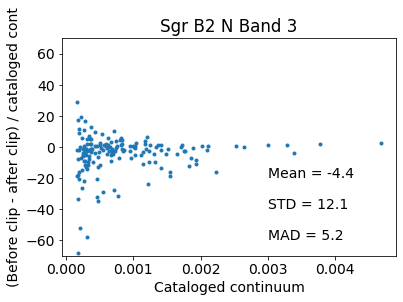

In [22]:
plt.scatter(catNB3_m['peak'],np.array(errors_arr3),marker='.')
plt.xlabel('Cataloged continuum')
plt.ylabel('(Before clip - after clip) / cataloged cont')
plt.ylim(-70,70)
mean = np.nanmean(errors_arr3)
std = np.nanstd(errors_arr3)
mad = mad_std(errors_arr3, ignore_nan=True)
plt.text(0.003,-20,'Mean = '+str(round(mean,1)), fontsize=14)
plt.text(0.003,-40,'STD = '+str(round(std,1)), fontsize = 14)
plt.text(0.003,-60,'MAD = '+str(round(mad,1)), fontsize = 14)
plt.title('Sgr B2 N Band 3')
#plt.axvline(np.nanmin(catNB3_m['ring_std'])*10)
# negative number means the absorption dominates
#plt.savefig('linesub3.png', dpi=300,bbox_inches='tight')

Text(0.5, 1.0, 'Sgr B2 N Band 6')

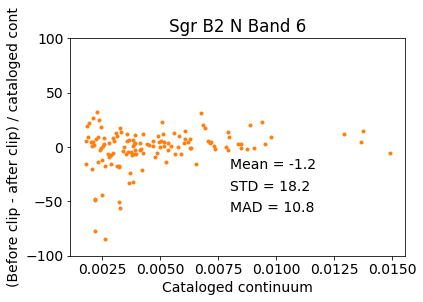

In [23]:
plt.scatter(catNB6_m['peak'],np.array(errors_arr6),marker='.', color = 'tab:orange')
plt.xlabel('Cataloged continuum')
plt.ylabel('(Before clip - after clip) / cataloged cont')
plt.ylim(-100,100)
mean = np.nanmean(errors_arr6)
std = np.nanstd(errors_arr6)
mad = mad_std(errors_arr6, ignore_nan=True)
plt.text(0.008,-20,'Mean = '+str(round(mean,1)), fontsize=14)
plt.text(0.008,-40,'STD = '+str(round(std,1)), fontsize = 14)
plt.text(0.008,-60,'MAD = '+str(round(mad,1)), fontsize = 14)
plt.title('Sgr B2 N Band 6')
#plt.axvline(np.nanmin(catNB6_m['ring_std'])*10)
# negative number means the absorption dominates
#plt.savefig('linesub6.png', dpi=300,bbox_inches='tight')